## Configuracion de entorno y carga de librerias

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, 
                             roc_curve, f1_score, matthews_corrcoef, make_scorer)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.spatial.distance import cdist
import shap
import warnings

# Configuración Global
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 300 # Alta resolución para tesis
plt.rcParams['savefig.bbox'] = 'tight'

print ("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


## Carga y preprocesamiento de datos

In [10]:
# 1. Cargar datasets
train = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Training.csv")
test = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Test.csv")
ext = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_External.csv")

# 2. Separar Variables (X) y Clase (y)
target_col = 'Actividad' # Ajusta si tu columna tiene otro nombre
features = [c for c in train.columns if c != target_col]

print(f" Variables predictoras ({len(features)}): {features}")

X_train = train[features]
X_test = test[features]
X_ext = ext[features]

# 3. Codificación de Etiquetas (Label Encoding)
# Transformamos 'Act1' a 1 y 'Act-1' a 0 automáticamente
le = LabelEncoder()
y_train = le.fit_transform(train[target_col])
y_test = le.transform(test[target_col])
y_ext = le.transform(ext[target_col])

# Verificar mapeo para no confundirnos
print(f" Mapeo de clases: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"Dimensiones Training: {X_train.shape}")

 Variables predictoras (11): ['LOGPcons', 'MACCSFP125', 'PCR', 'Psi_e_A', 'P_VSA_ppp_D', 'Mp', 'SpMin1_Bh(p)', 'SHED_AL', 'SM12_AEA(ri)', 'P_VSA_s_3', 'MATS5m']
 Mapeo de clases: {'Act-1': np.int64(0), 'Act1': np.int64(1)}
Dimensiones Training: (4357, 11)


## Tuning

In [11]:
print("Iniciando búsqueda de hiperparámetros (GridSearch)...")

# Definición del espacio de búsqueda
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15, None],       # Controla la complejidad
    'min_samples_split': [2, 5, 10, 20],        # Evita divisiones muy específicas
    'min_samples_leaf': [1, 5, 10],             # Suaviza el modelo en las hojas
    'class_weight': [None, 'balanced']          # Crucial para sets desbalanceados
}

# Configuración del modelo base
dt = DecisionTreeClassifier(random_state=42)

# Ejecución del GridSearch optimizando por AUC-ROC (más robusto que accuracy)
grid_search = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    cv=10, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f" Mejor AUC en CV interna: {grid_search.best_score_:.4f}")

Iniciando búsqueda de hiperparámetros (GridSearch)...
Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Mejores parámetros: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
 Mejor AUC en CV interna: 0.7714


## Evaluacion de metricas

In [12]:
def calcular_metricas(model, X, y, nombre_set):
    # Predicciones
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    # Matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    # Cálculos manuales para especificidad
    sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        'Dataset': nombre_set,
        'Accuracy': accuracy_score(y, y_pred),
        'Sensibilidad (TP Rate)': sensibilidad,
        'Especificidad (TN Rate)': especificidad,
        'AUC-ROC': roc_auc_score(y, y_prob),
        'Kappa': (2 * (tp * tn - fn * fp) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))),
        'MCC': matthews_corrcoef(y, y_pred),
        'F1-Score': f1_score(y, y_pred)
    }

# Calcular para los 3 sets
res_train = calcular_metricas(best_model, X_train, y_train, 'Training')
res_test = calcular_metricas(best_model, X_test, y_test, 'Test Interno')
res_ext = calcular_metricas(best_model, X_ext, y_ext, 'Validación Externa')

# Mostrar tabla
df_res = pd.DataFrame([res_train, res_test, res_ext]).set_index('Dataset')
print(" TABLA DE RENDIMIENTO:")
display(df_res.round(3))


 TABLA DE RENDIMIENTO:


,Accuracy,Sensibilidad (TP Rate),Especificidad (TN Rate),AUC-ROC,Kappa,MCC,F1-Score
Dataset,,,,,,,
Training,0.755,0.877,0.614,0.819,0.499,0.513,0.793
Test Interno,0.743,0.894,0.570,0.802,0.473,0.495,0.788
Validación Externa,0.872,0.937,0.209,0.657,0.156,0.156,0.930


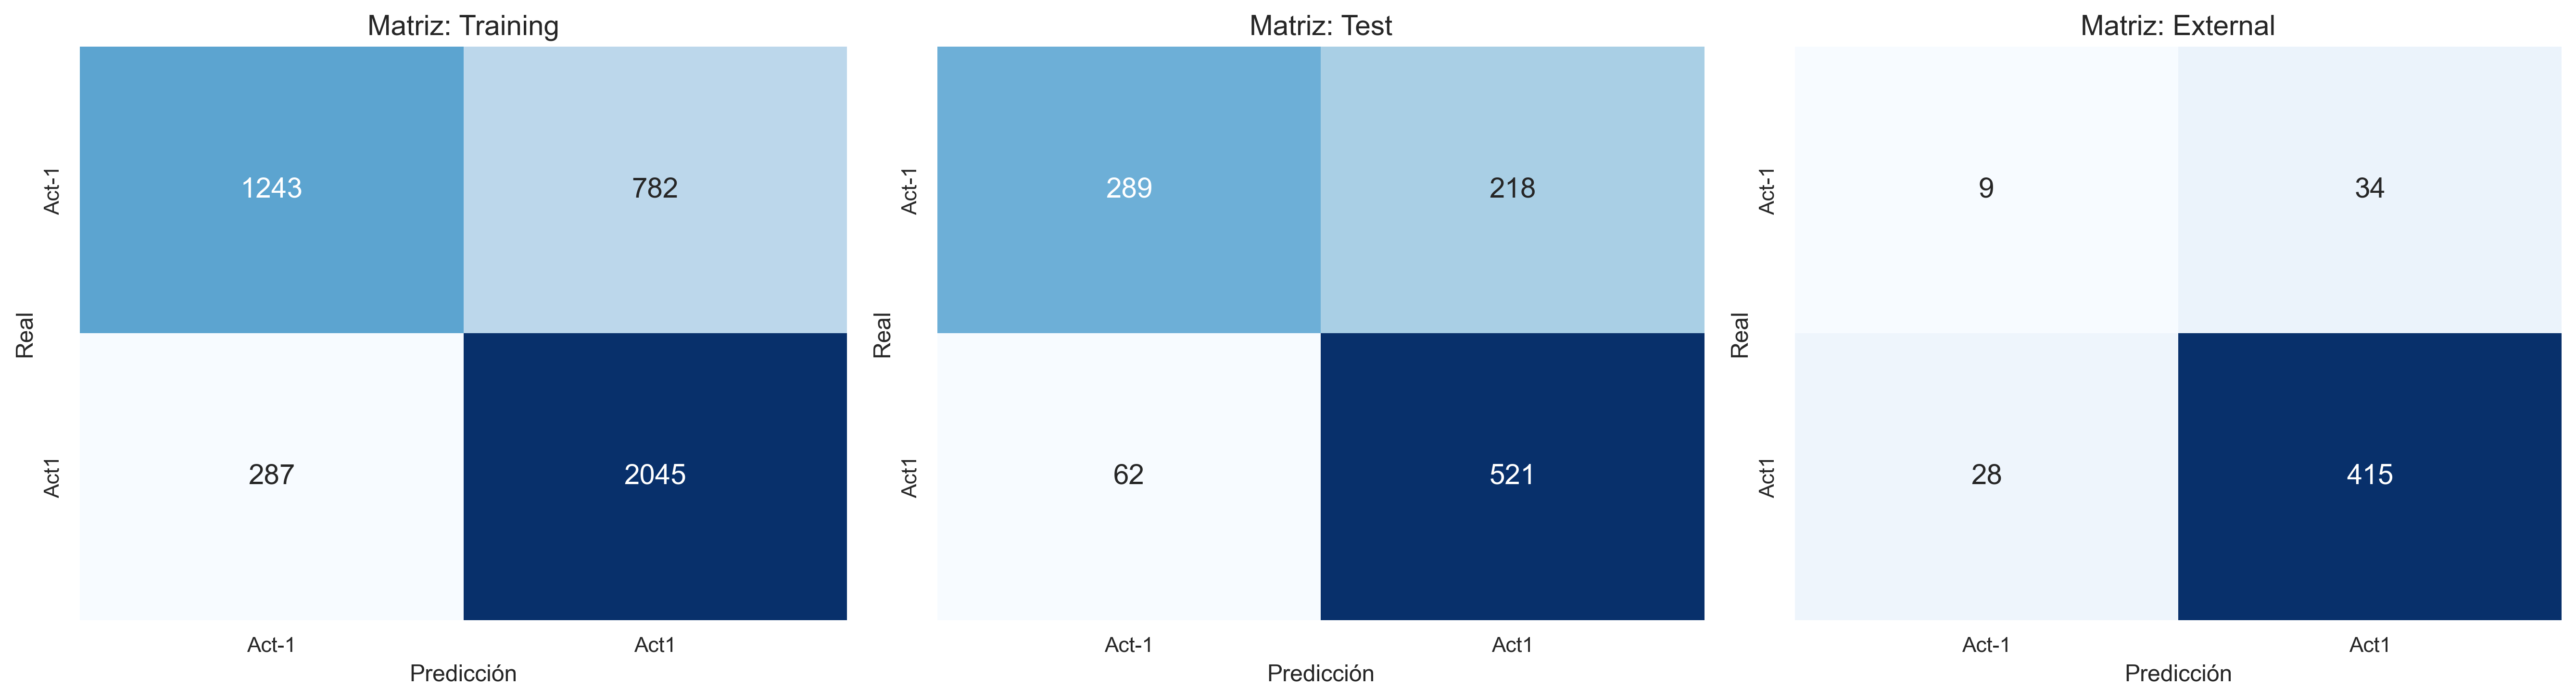

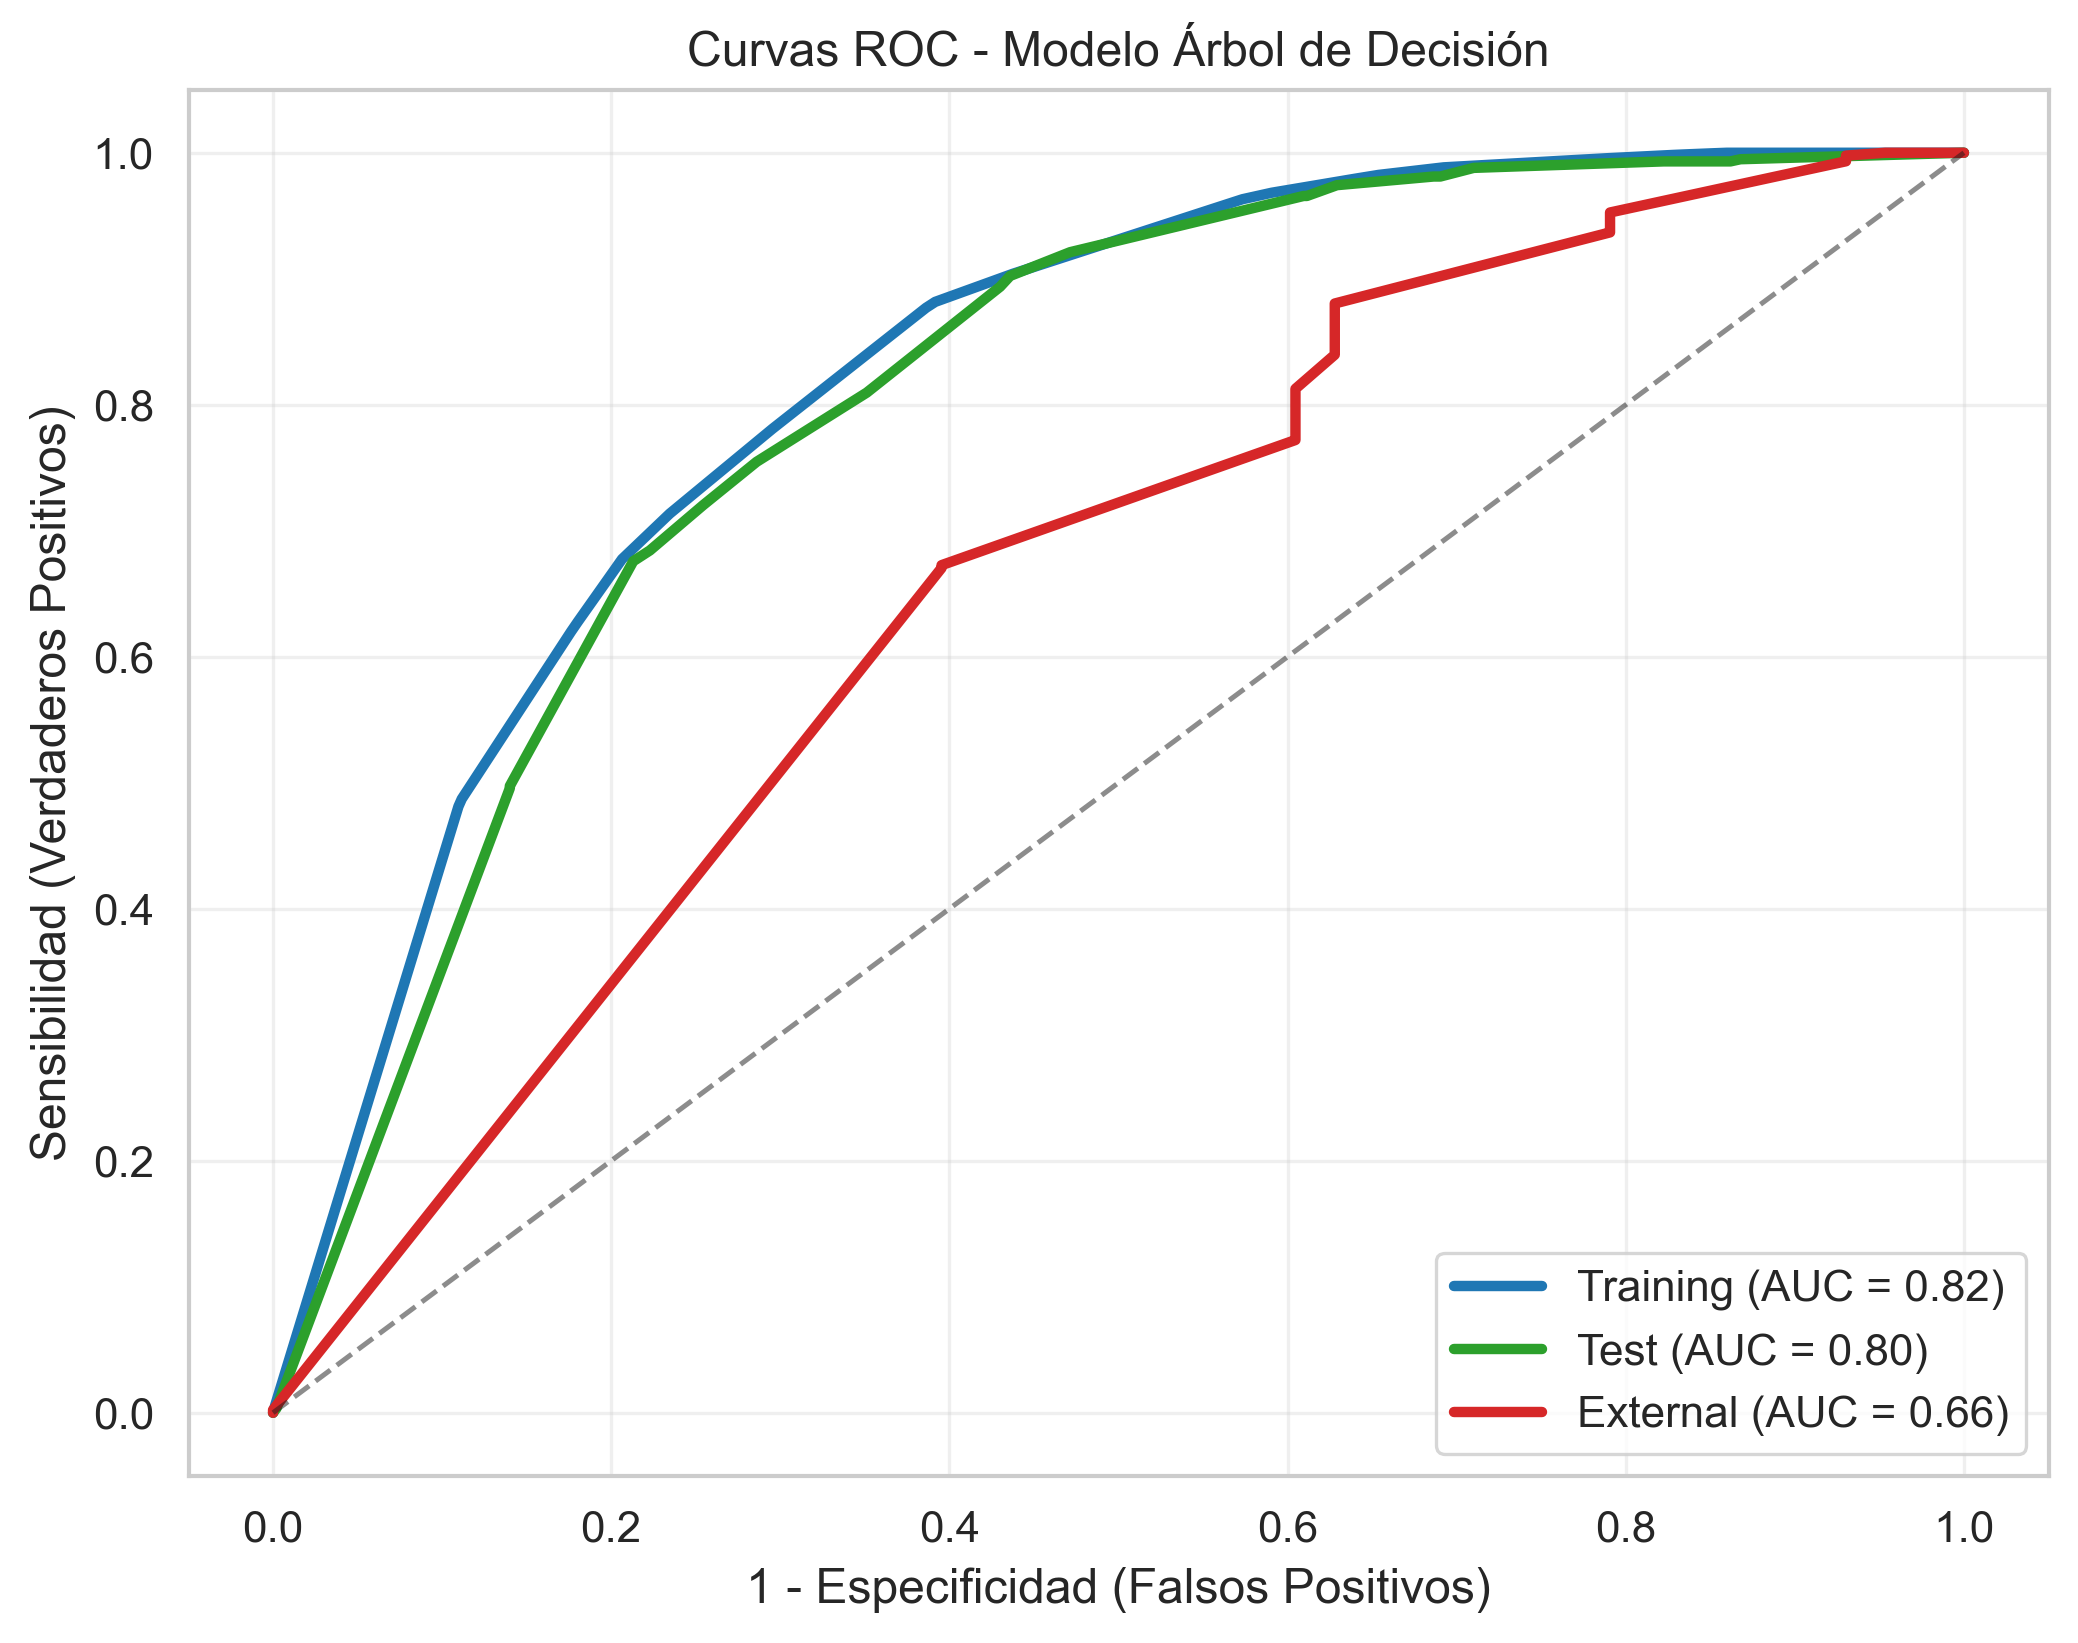

In [13]:
# A. MATRICES DE CONFUSIÓN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sets = [(X_train, y_train, 'Training'), (X_test, y_test, 'Test'), (X_ext, y_ext, 'External')]

for i, (X_curr, y_curr, title) in enumerate(sets):
    cm = confusion_matrix(y_curr, best_model.predict(X_curr))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 14})
    axes[i].set_title(f'Matriz: {title}', fontsize=14)
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()

# B. CURVAS ROC COMPARATIVAS
plt.figure(figsize=(8, 6))

colors = ['#1f77b4', '#2ca02c', '#d62728'] # Azul, Verde, Rojo
for (X_curr, y_curr, title), color in zip(sets, colors):
    y_prob = best_model.predict_proba(X_curr)[:, 1]
    fpr, tpr, _ = roc_curve(y_curr, y_prob)
    auc = roc_auc_score(y_curr, y_prob)
    plt.plot(fpr, tpr, label=f'{title} (AUC = {auc:.2f})', color=color, lw=2.5)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('1 - Especificidad (Falsos Positivos)')
plt.ylabel('Sensibilidad (Verdaderos Positivos)')
plt.title('Curvas ROC - Modelo Árbol de Decisión')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


### matriz
Para el set externo, una alta concentracion en el cuadrante de Verdaderos positivos(TP) indica que el modelo es altamente sensible, ideal para Virtual Screening. La precensia de casos en FP indica que el modelo tiende a sobreestimar la actividad, priorizando no perder farmacos potenciales.
El set de training y test se ven similares y equilibrados, la diagonal de aciertos es oscura y densa, por lo que no hay un overfitting

### curvas ROC
Las curvas Azul (Training) y Verde (Test) están muy juntas y elevadas (AUC > 0.80). Esto valida la estabilidad interna.

La curva Roja (External) cae por debajo (AUC ~0.67).

Interpretación: El modelo es excelente clasificando "sí/no" dentro de lo que conoce, pero cuando sale al mundo real (External), le cuesta más ordenar qué tan seguro está de cada predicción, aunque al final acierte la clase.

## Interpretabilidad

🌳 Generando gráfico del árbol (Niveles superiores)...


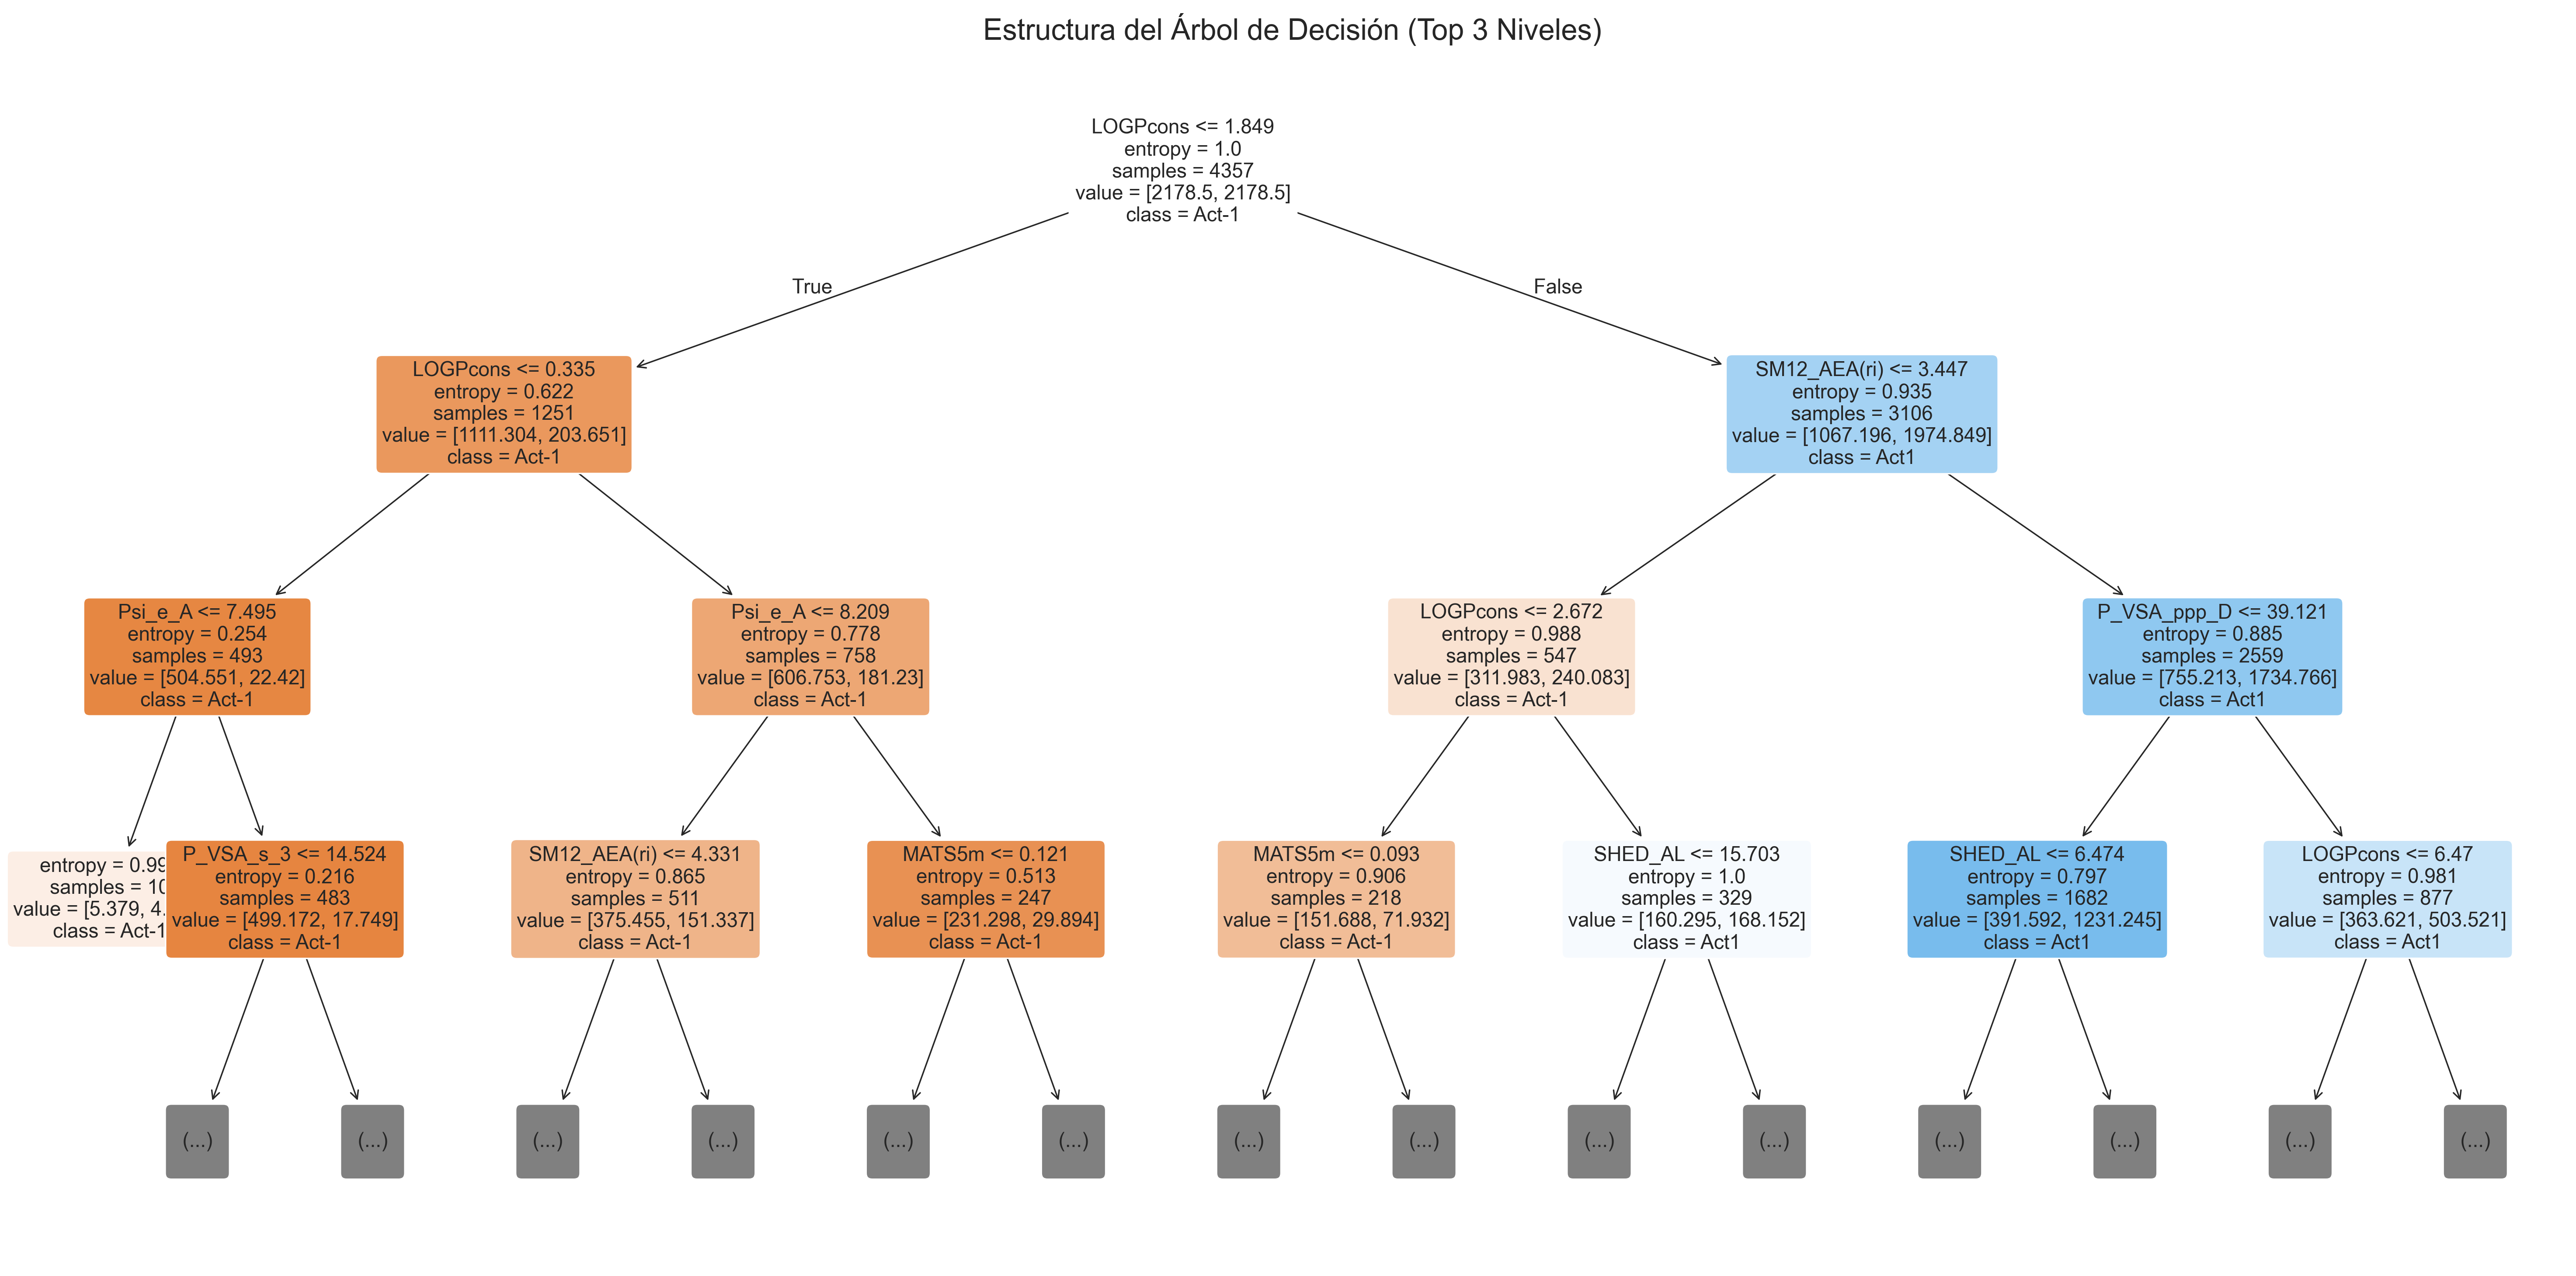


📜 REGLAS DEL ÁRBOL (Lógica Completa):
|--- LOGPcons <= 1.85
|   |--- LOGPcons <= 0.34
|   |   |--- Psi_e_A <= 7.49
|   |   |   |--- class: 0
|   |   |--- Psi_e_A >  7.49
|   |   |   |--- P_VSA_s_3 <= 14.52
|   |   |   |   |--- SHED_AL <= 5.31
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SHED_AL >  5.31
|   |   |   |   |   |--- class: 0
|   |   |   |--- P_VSA_s_3 >  14.52
|   |   |   |   |--- P_VSA_ppp_D <= 244.55
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- P_VSA_ppp_D >  244.55
|   |   |   |   |   |--- class: 0
|   |--- LOGPcons >  0.34
|   |   |--- Psi_e_A <= 8.21
|   |   |   |--- SM12_AEA(ri) <= 4.33
|   |   |   |   |--- SpMin1_Bh(p) <= 2.11
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SpMin1_Bh(p) >  2.11
|   |   |   |   |   |--- class: 0
|   |   |   |--- SM12_AEA(ri) >  4.33
|   |   |   |   |--- class: 1
|   |   |--- Psi_e_A >  8.21
|   |   |   |--- MATS5m <= 0.12
|   |   |   |   |--- PCR <= 1.25
|   |   |   |   |   |--- class: 0
|   |   |   |   |---

In [14]:
from sklearn.tree import plot_tree, export_text

# 1. OPCIÓN VISUAL: Árbol Gráfico (Solo niveles superiores)
# ==========================================================
print("🌳 Generando gráfico del árbol (Niveles superiores)...")

plt.figure(figsize=(25, 12))  # Tamaño gigante para que se vea bien
plot_tree(best_model, 
          feature_names=features, 
          class_names=le.classes_.astype(str),
          filled=True,        # Colores según la clase
          rounded=True,       # Bordes redondeados
          fontsize=11,        # Tamaño de letra legible
          max_depth=3)        # IMPORTANTE: Solo mostramos los primeros 3 niveles
                              # Si quitas esto, el árbol será ilegible si es muy grande.

plt.title("Estructura del Árbol de Decisión (Top 3 Niveles)", fontsize=16)
plt.savefig("Arbol_Decision_Plot.png", dpi=300, bbox_inches='tight') # Guardar imagen HD
plt.show()

# 2. OPCIÓN TEXTO: Reglas Lógicas (Estilo Weka)
# ==========================================================
print("\n📜 REGLAS DEL ÁRBOL (Lógica Completa):")
# Esto genera el texto tipo: "|--- LogP <= 1.84"
reglas = export_text(best_model, feature_names=features)
print(reglas)

# Guardar las reglas en un archivo de texto para la tesis
with open("Reglas_Arbol.txt", "w") as f:
    f.write(reglas)
print("✅ Reglas guardadas en 'Reglas_Arbol.txt'")

### Arbol
Este arbol aporta la transparencia mecanistica. Permite definir las reglas quimicas explicitas, por ejemplo, 'Para que un compuesto sea permeable en PAMPA, debe tener una lipofilicidad mayor a 1.84 y una polarizabilidad especifica''. Esto le da coherencia fisicoquimica al modelo.
La lipofilicidad es el juez principal, si no cumples el requisito minimo, se va a la rama izquierda(inactivo) y si se cumple se pasa a evaluar otras variables(MAACSFP125, P_VSA...)


🤖 Calculando SHAP Values (Interpretación del modelo)...
Formato detectado: Array (4357, 11, 2)


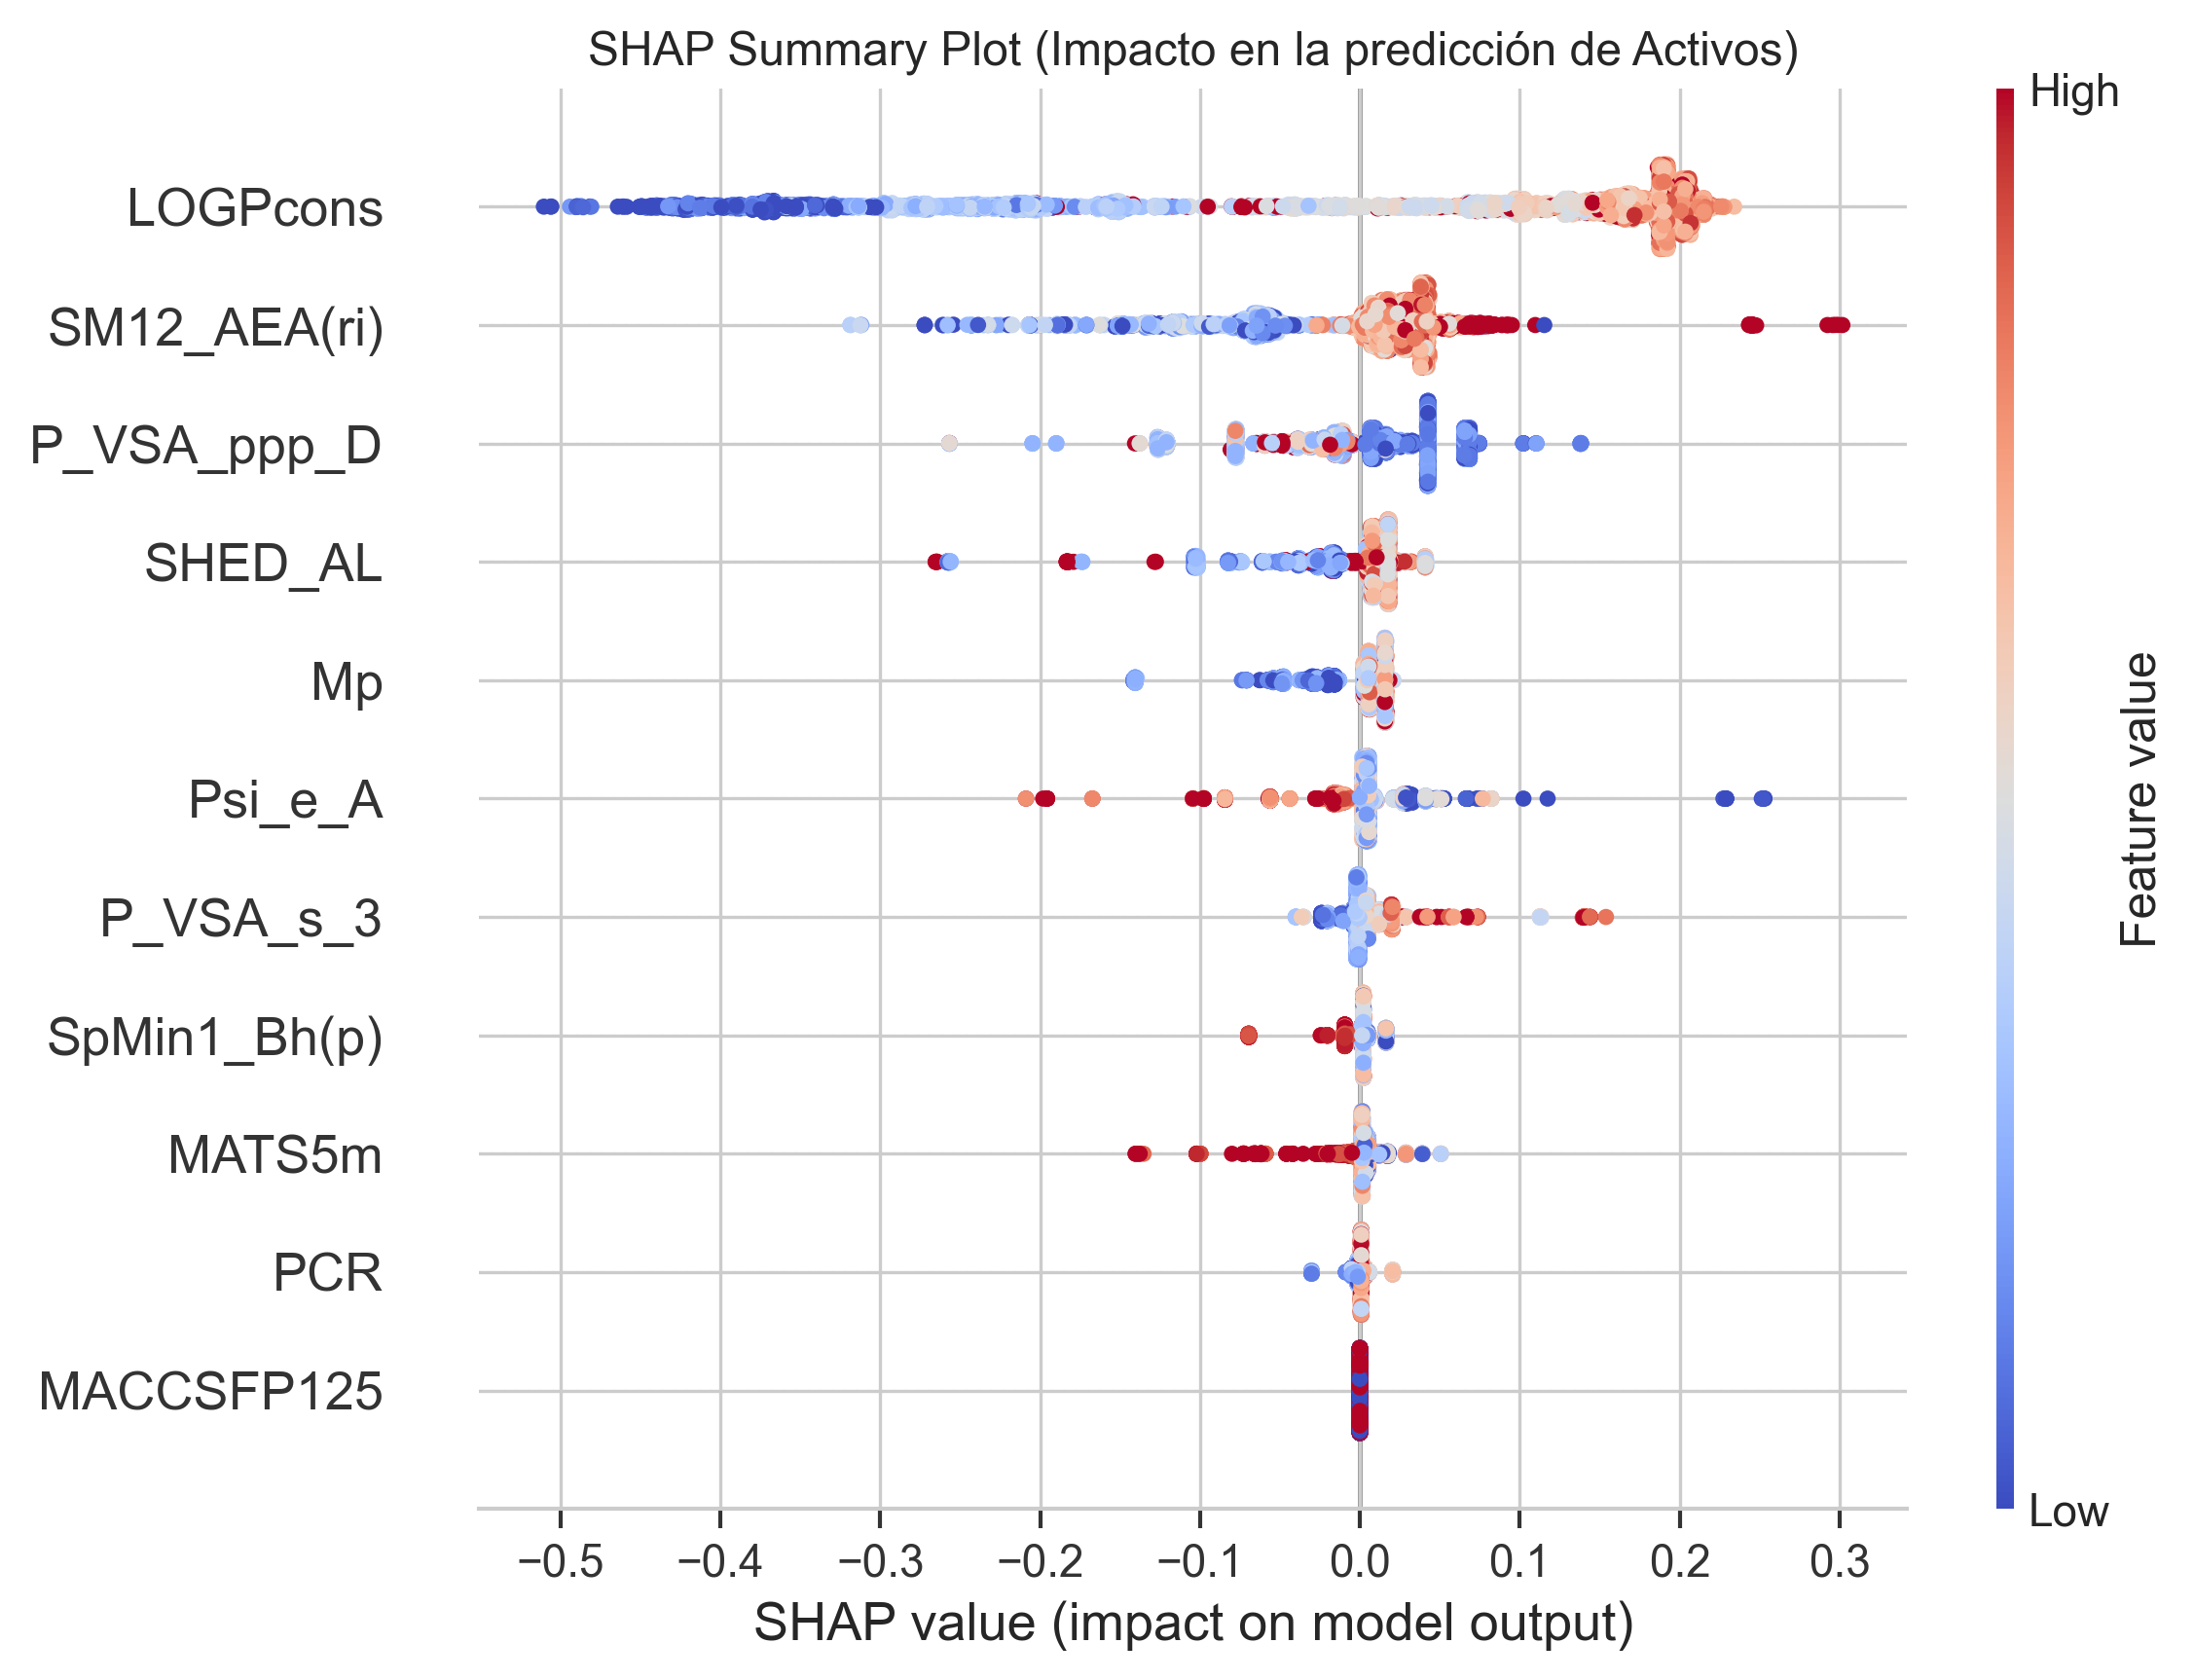

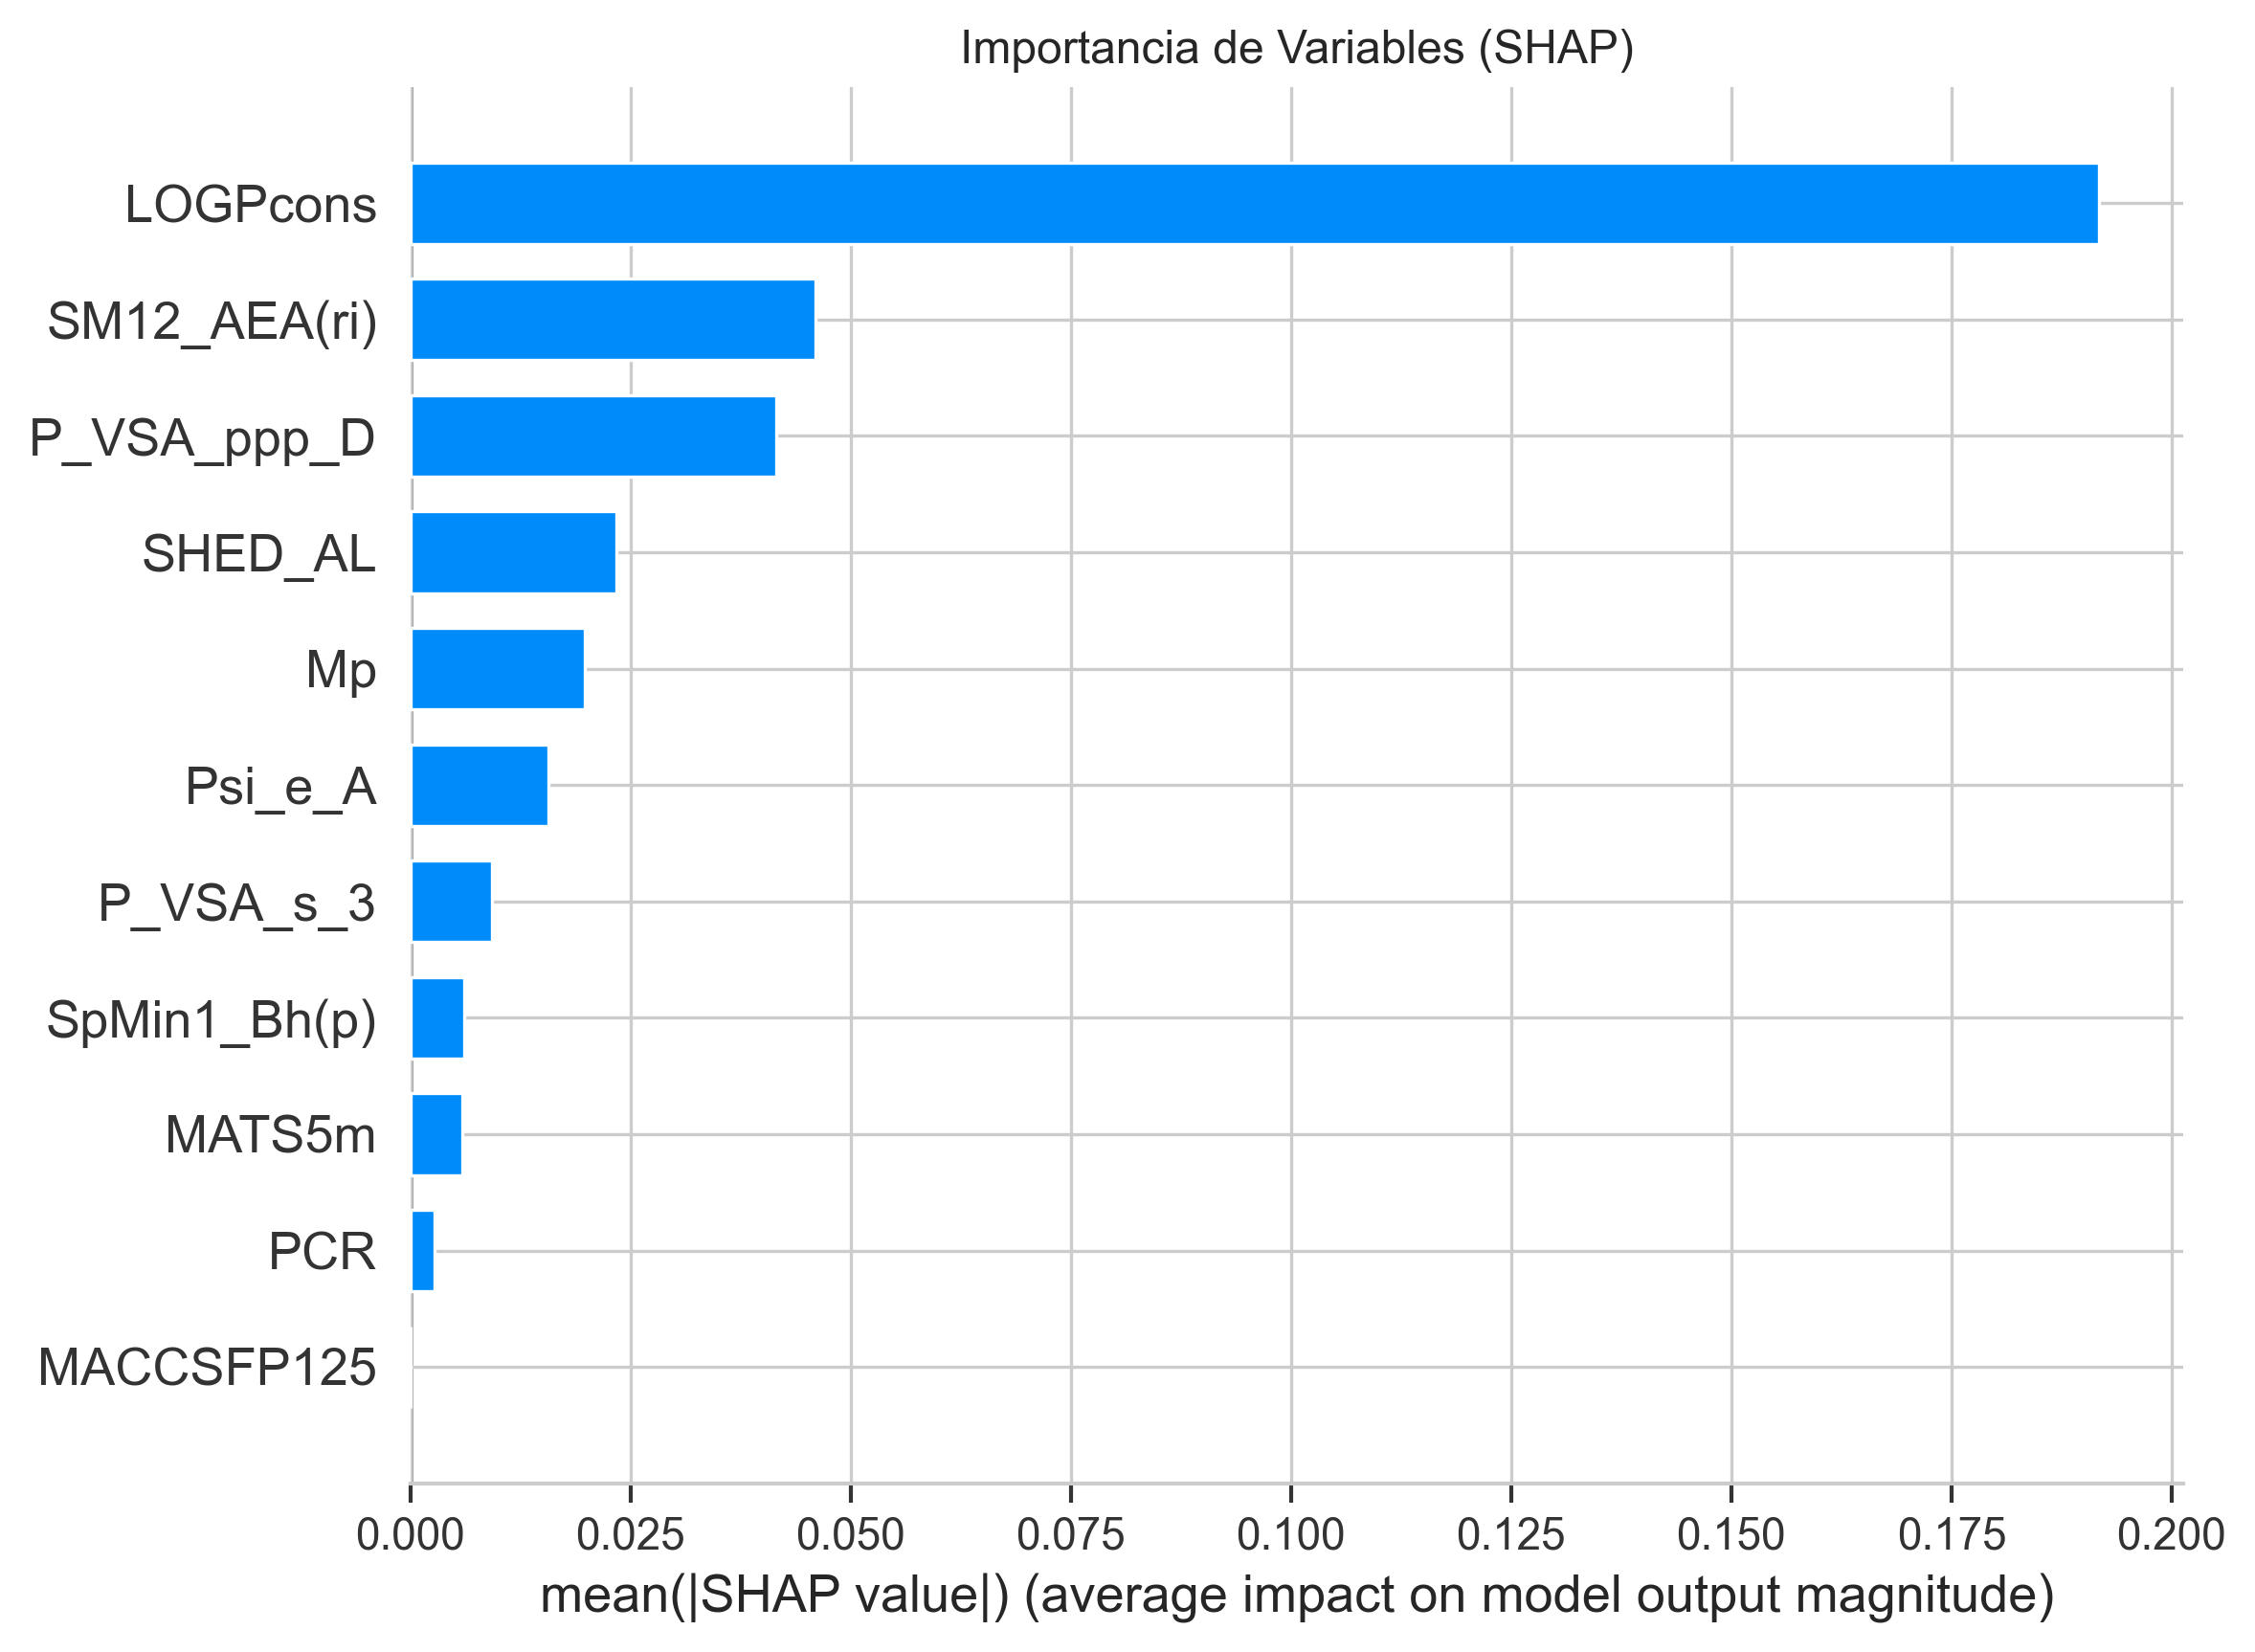

In [15]:
# 6. SHAP VALUES (Explicabilidad Avanzada) - CORREGIDO
# =============================================================================
print("\n🤖 Calculando SHAP Values (Interpretación del modelo)...")

# 1. Calcular valores
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

# 2. CORRECCIÓN DE DIMENSIONES (Detectar si es lista o array 3D)
vals_to_plot = None

if isinstance(shap_values, list):
    # Caso A: Es una lista [Clase0, Clase1]. Usamos la Clase 1 (Activos).
    print("Formato detectado: Lista (Estilo antiguo)")
    vals_to_plot = shap_values[1]
else:
    # Caso B: Es un array numpy. Verificamos dimensiones.
    print(f"Formato detectado: Array {shap_values.shape}")
    if len(shap_values.shape) == 3:
        # Forma: (n_samples, n_features, n_classes)
        # Queremos: todas las filas, todas las columnas, clase 1
        vals_to_plot = shap_values[:, :, 1]
    elif len(shap_values.shape) == 2:
        # Forma: (n_samples, n_features) -> Ya es la clase correcta
        vals_to_plot = shap_values
    else:
        raise ValueError("Formato de SHAP no reconocido.")

# 3. Graficar
plt.figure()
plt.title("SHAP Summary Plot (Impacto en la predicción de Activos)")
# Usamos vals_to_plot que ya tiene la forma correcta (N_muestras, N_features)
shap.summary_plot(vals_to_plot, X_train, plot_type="dot", show=False, cmap='coolwarm')
plt.show()

plt.figure()
plt.title("Importancia de Variables (SHAP)")
shap.summary_plot(vals_to_plot, X_train, plot_type="bar", show=False, cmap='coolwarm')
plt.show()

### Beeswarm
En la fila de LOGPcons, es por lejos la variable mas potente.
Los puntos rojos, se mueven fuertemente hacia la derecha(impacto positivo)
Para atravesar la bicapa lipidica de la membrana, la molecula debe ser lipofilica. 
MACCSFP125
 Aromaticidad, la presencia de estos anillos favorece la interaccion con las colas hidrofobicas de los fosfolipidos mediante fuerzas ($\pi$-$\pi$). Las estructuras planas y aromaticas permean mejor que las cadenas alifaticas simples.
MP. 
Polarizabilidad atomica media, representa la ''blandura'' de la nube electronica, una nube polarizada permite generar dipolos inducidos, estas fuerzas son cruciales para moverse dentro de un entorno apolar en la membrana. Las moleculas muy rigidas electronicamente tienen mas dificultad
PCR.
 Indice topologico de complejidad y ramificacion molecular, relaciona caminos multiples vs simples en el grafo molecula. Una estructura más compacta y ramificada es cinéticamente más favorable para la difusión a través de la membrana que estructuras lineales o extendidas. Estas suelen tener un radio hidrodinámico menor que sus isómeros lineales, lo que facilita su paso a través de los espacios intersticiales de la bicapa lipídica una vez que han cumplido con el requisito de lipofilicidad.
 P_VSA_ppp_D
 mide la distibuicion de la carga electroestatica en la superficie de van der waals. Los puntos rojos tienden a la izquierda, por lo que las zonas de alta densidad de carga o potencial positivo/negativo fuerte en la superficie crean una "cáscara de hidratación" (agua pegada a la molécula). Para permear, la molécula debe despojarse de esa agua (desolvatación), lo cual cuesta energía. Si este descriptor es alto, la desolvatación es difícil y la permeabilidad baja.

## Dominio de aplicabilidad

 Evaluando Dominio de Aplicabilidad (AD)...


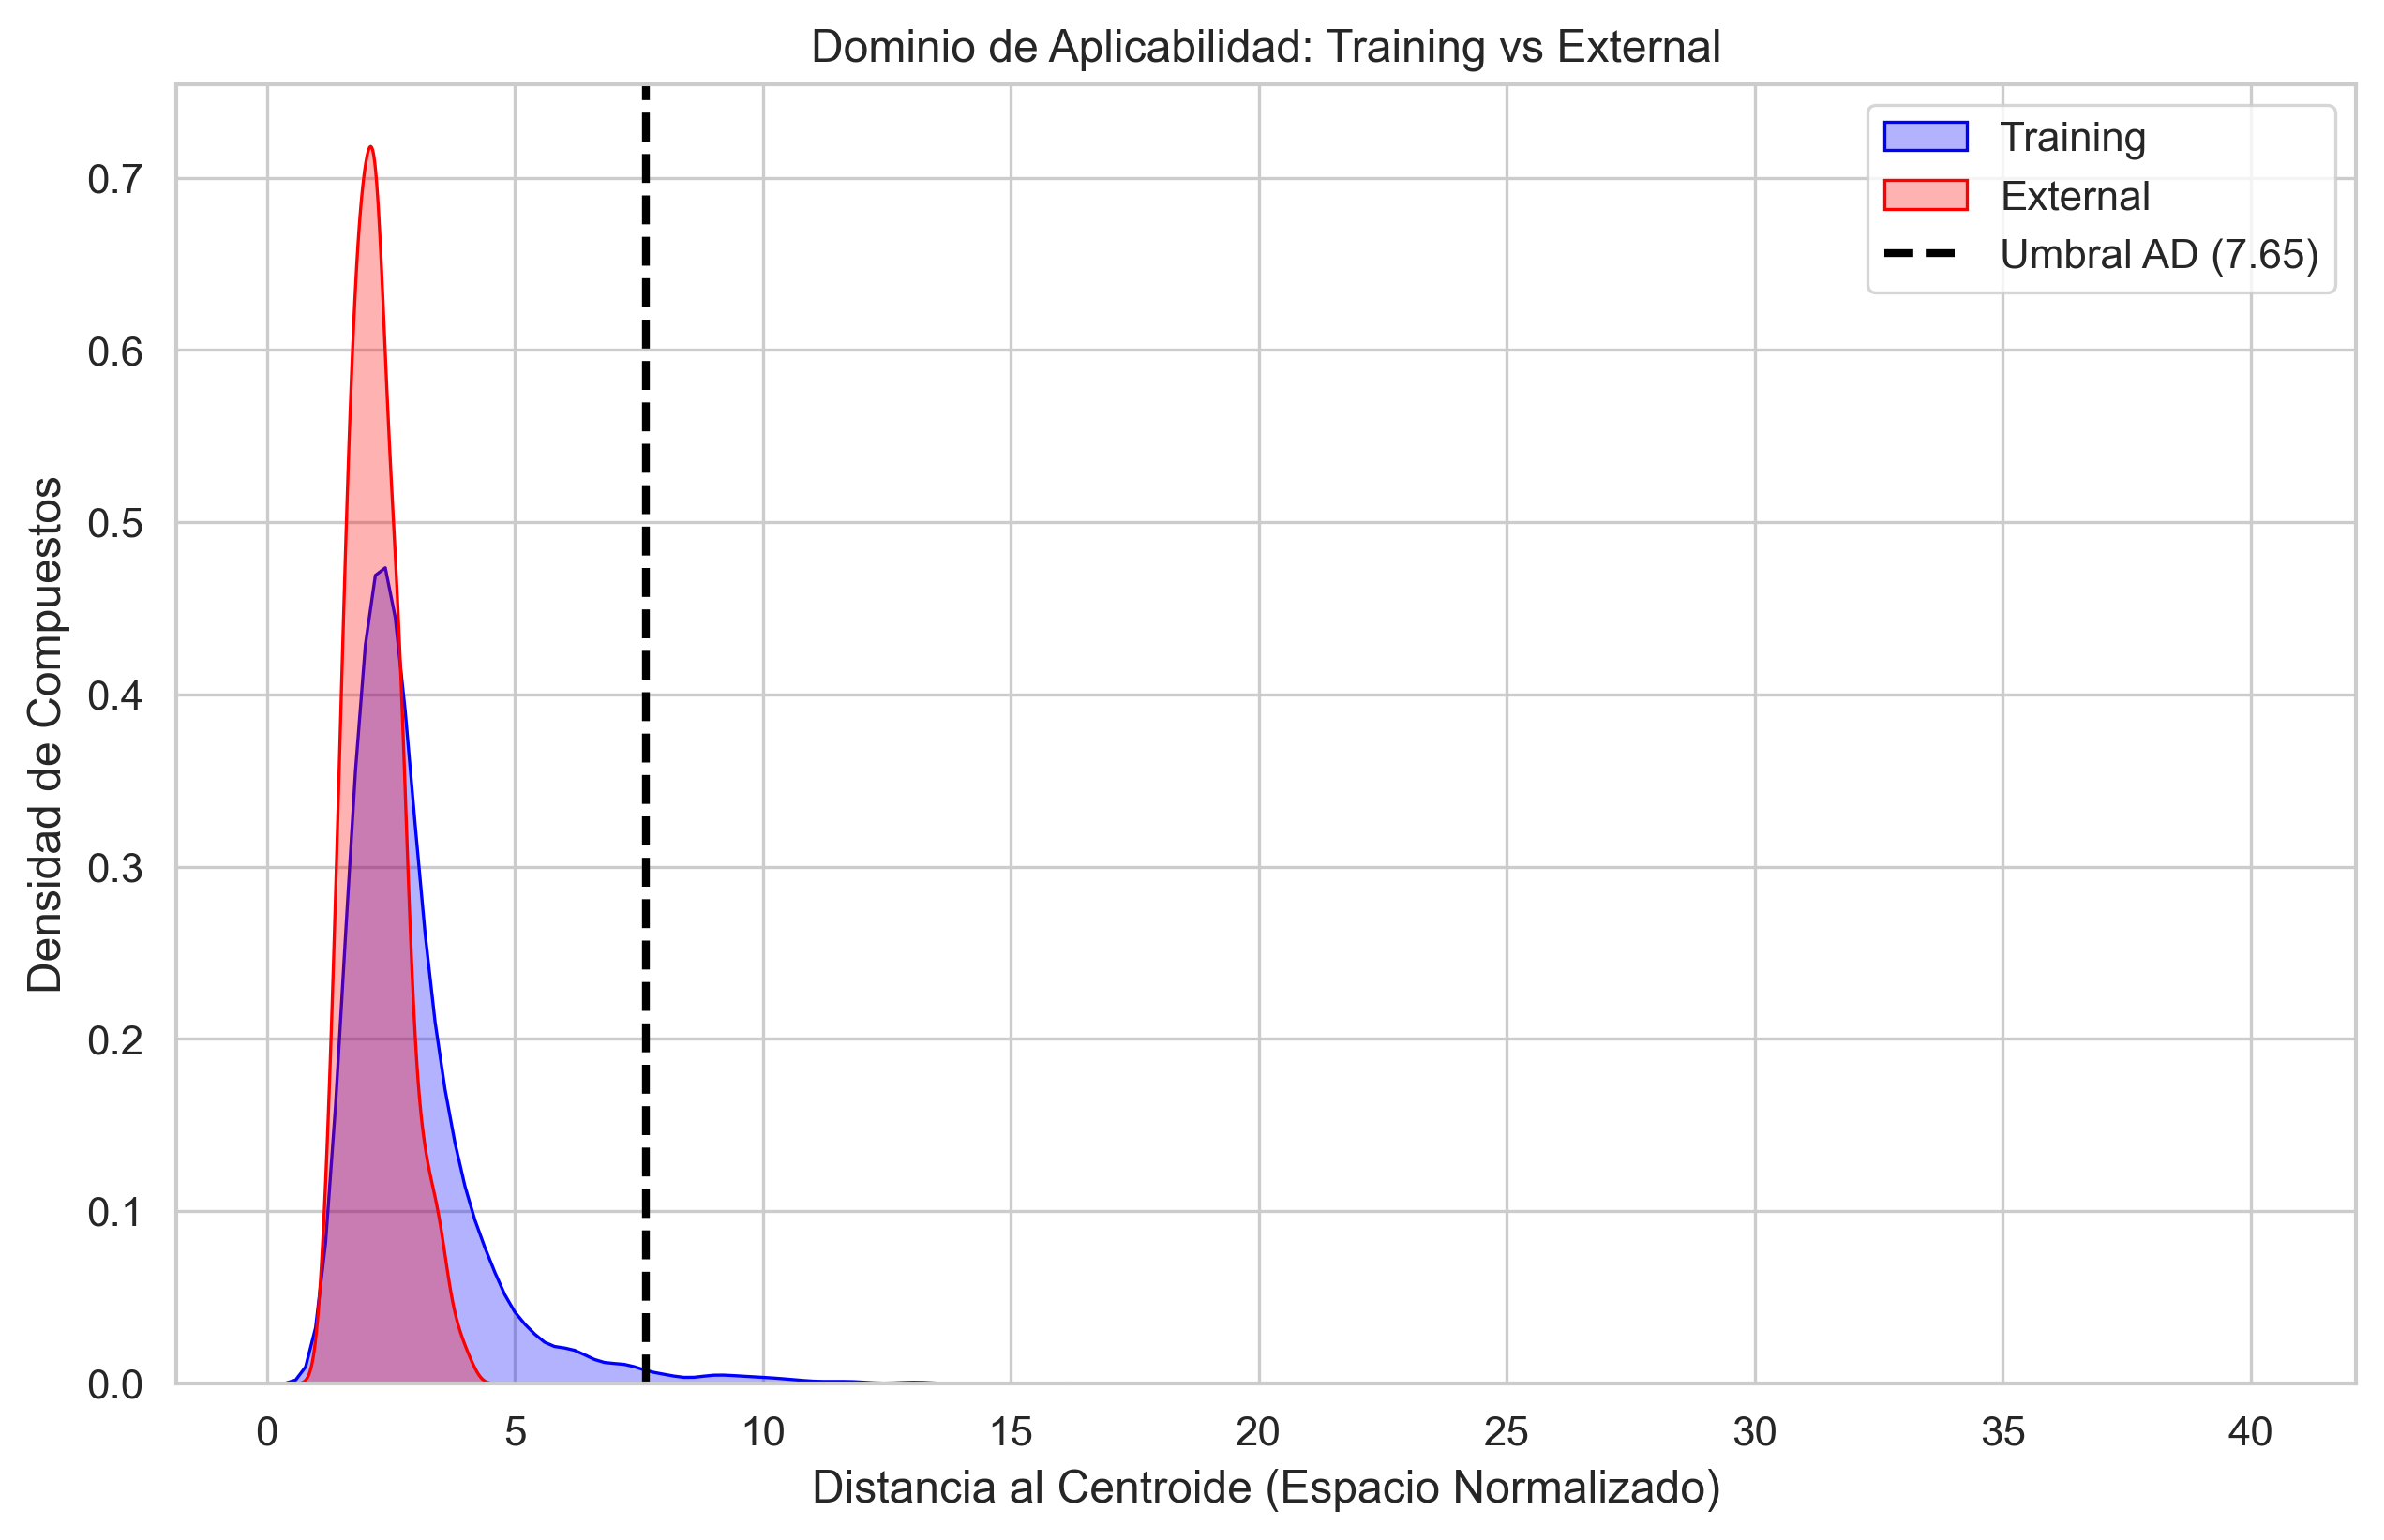

📉 Compuestos externos fuera del dominio: 0 de 486 (0.0%)


In [16]:
print(" Evaluando Dominio de Aplicabilidad (AD)...")

# 1. Estandarizar el espacio químico (basado en Train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_ext_scaled = scaler.transform(X_ext)

# 2. Calcular Centroide y Distancias
centroid = np.mean(X_train_scaled, axis=0).reshape(1, -1)
dist_train = cdist(X_train_scaled, centroid, 'euclidean')
dist_test = cdist(X_test_scaled, centroid, 'euclidean')
dist_ext = cdist(X_ext_scaled, centroid, 'euclidean')

# 3. Definir Umbral (Z = 3.0, criterio estadístico estándar)
# Alternativa: Percentil 95 (np.percentile(dist_train, 95))
ad_threshold = np.mean(dist_train) + 3 * np.std(dist_train)

# 4. Visualización de Densidades
plt.figure(figsize=(10, 6))
sns.kdeplot(dist_train.flatten(), fill=True, color='blue', label='Training', alpha=0.3)
sns.kdeplot(dist_ext.flatten(), fill=True, color='red', label='External', alpha=0.3)
plt.axvline(ad_threshold, color='black', linestyle='--', lw=2, label=f'Umbral AD ({ad_threshold:.2f})')

plt.xlabel('Distancia al Centroide (Espacio Normalizado)')
plt.ylabel('Densidad de Compuestos')
plt.title('Dominio de Aplicabilidad: Training vs External')
plt.legend()
plt.show()

# 5. Reporte de Outliers
n_out = np.sum(dist_ext > ad_threshold)
print(f"📉 Compuestos externos fuera del dominio: {n_out} de {len(dist_ext)} ({n_out/len(dist_ext)*100:.1f}%)")